# Week 1: Statistical Validation of RAG Improvements

When optimizing RAG systems, it's not enough to just see improvements in metrics—we need to be confident those improvements are real and reproducible. This notebook introduces statistical techniques to validate that your RAG optimizations are truly making a difference.

## What You'll Learn

Through hands-on analysis of our Text-to-SQL retrieval experiments, you'll discover:

- How to use bootstrapping to estimate the reliability of your improvements
- Ways to determine if differences between models are statistically significant
- Techniques to visualize confidence intervals and interpret their overlap
- Methods to make data-driven decisions about model selection

## Why Statistical Validation Matters

Imagine you've just spent weeks implementing a complex re-ranking system, only to find that your 2% improvement in recall might be due to random chance. Statistical validation helps you:

1. Avoid investing in "improvements" that don't reliably help
2. Quantify your confidence in observed performance differences
3. Make informed decisions about architectural tradeoffs
4. Build more robust and reliable RAG systems

## Prerequisites

Before starting this notebook, please run:
- `1. synthetic_questions.ipynb` to generate the evaluation dataset
- `2. benchmark_retrieval.ipynb` to generate the retrieval results we'll analyze

## What We'll Cover

We'll walk through three key aspects of statistical validation:

1. **Bootstrapping Analysis**: Learn how to simulate multiple experimental runs to understand the stability of your results
2. **Confidence Intervals**: Visualize the range of likely performance values for different approaches
3. **Statistical Testing**: Use t-tests to determine if observed differences are statistically significant

Let's dive in and learn how to validate your RAG improvements with statistical rigor.

## Simulating Multiple Runs with Bootstrapping

We want to have code that's easily adaptable if we want to compare the results of different experiments. A good approach is to define a configuration class that we can easily scale to other experiments as seen below. This makes adding new experiments to compare as simple as adding a new configuration object.

Because we've logged our experiment results with braintrust, it's easy to fetch the results. 

In [3]:
from dataclasses import dataclass
import braintrust


@dataclass
class ExperimentConfig:
    experiment_id: str
    project_name: str
    label: str

    def get_results(self):
        return [
            {
                "preds": [item["id"] for item in row["output"]],
                "labels": [row["metadata"]["chunk_id"]],
            }
            for row in braintrust.init(
                project=self.project_name, experiment=self.experiment_id, open=True
            )
            if row["root_span_id"] == row["span_id"]
        ]


configs = [
    ExperimentConfig(
        experiment_id="85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-small",
        project_name="Text-2-SQL",
        label="text-embedding-3-small",
    ),
    ExperimentConfig(
        experiment_id="85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-large",
        project_name="Text-2-SQL",
        label="text-embedding-3-large",
    ),
]

In [4]:
# Define some helper functions to calculate mrr and recall
def calculate_mrr(predictions: list[str], gt: list[str]):
    mrr = 0
    for label in gt:
        if label in predictions:
            # Find the relevant item that has the smallest index
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr


def calculate_recall(predictions: list[str], gt: list[str]):
    # Calculate the proportion of relevant items that were retrieved
    return len([label for label in gt if label in predictions]) / len(gt)


metrics = [("recall", calculate_recall), ("mrr", calculate_mrr)]
k = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

In [5]:
import numpy as np
import pandas as pd


def bootstrap_samples(config: ExperimentConfig, n_samples: int = 1000):
    means_list = []
    stds_list = []
    items = config.get_results()

    # Sample with replacement n_samples times
    for _ in range(n_samples):
        sample = np.random.choice(items, size=len(items), replace=True)

        sample_scores = []

        # For each sample, we treat it as a new experiment and compute the metrics we care about
        for row in sample:
            row_scores = {}
            for metric_name, metric_fn in metrics:
                for subset_k in k:
                    metric_key = f"{metric_name}@{subset_k}"
                    row_scores[metric_key] = metric_fn(
                        row["preds"][:subset_k], row["labels"]
                    )
            sample_scores.append(row_scores)

        # We then use this to compute means and standard deviations for each metric
        sample_df = pd.DataFrame(sample_scores)
        means_list.append(sample_df.mean().to_dict())
        stds_list.append(sample_df.std().to_dict())

    # Finally we return a dataframe of means and standard deviations for each metric
    means_df = pd.DataFrame(means_list)
    stds_df = pd.DataFrame(stds_list)

    return means_df, stds_df

## Visualising Confidence intervals

We want to see if the differences are statistically significant. The easiest way to do so is to plot the confidence interval for our bootstrapped results and see if they overlap. 

If we have a large confidence interval, we might need to increase the number of trials we're running in our experiment. But if our confidence intervals overlap, then we should be worried about the difference in performance between the two models. This is because there is a chance ti might be due to chance.

In [6]:
from dataclasses import dataclass
from typing import Dict


@dataclass
class BootstrapResults:
    label: str
    means: Dict[str, float]
    stds: Dict[str, float]
    ci_lower: Dict[str, float]
    ci_upper: Dict[str, float]


def calculate_bootstrap_stats(
    means_df: pd.DataFrame, stds_df: pd.DataFrame, label: str
) -> BootstrapResults:
    """Calculate bootstrap statistics for a given experiment config"""
    # Calculate mean and confidence intervals for each metric
    results = {}
    ci_lower = {}
    ci_upper = {}
    stds = {}

    # For each metric column
    for col in means_df.columns:
        results[col] = means_df[col].mean()
        stds[col] = stds_df[col].std()
        ci_lower[col] = np.percentile(means_df[col], 2.5)
        ci_upper[col] = np.percentile(means_df[col], 97.5)

    return BootstrapResults(
        means=results,
        ci_lower=ci_lower,
        ci_upper=ci_upper,
        label=label,
        stds=stds,
    )

In [7]:
bootstrap_dfs = [bootstrap_samples(config, n_samples=1000) for config in configs]
bootstrap_results = [
    calculate_bootstrap_stats(dfs[0], dfs[1], config.label)
    for dfs, config in zip(bootstrap_dfs, configs)
]

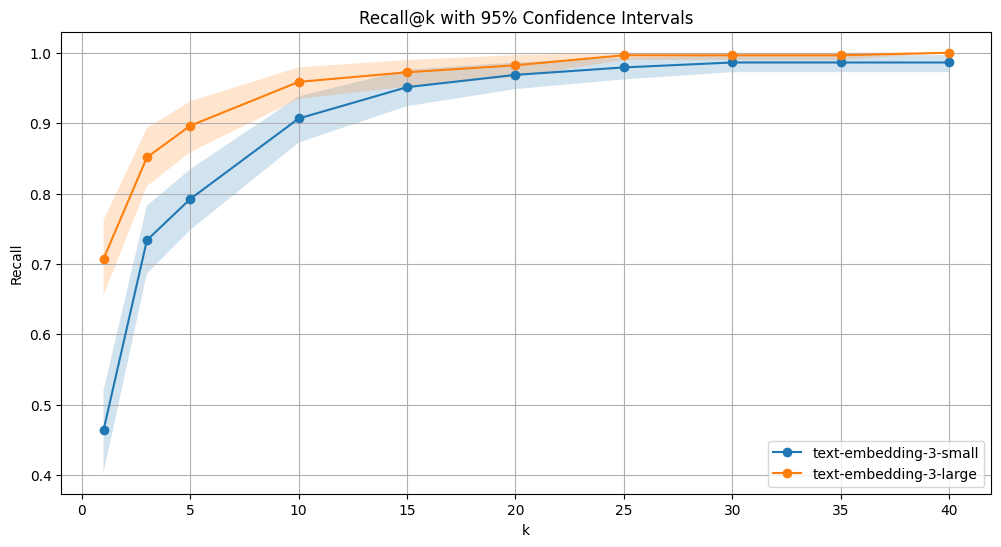

In [8]:
import matplotlib.pyplot as plt
from typing import List


def plot_recall_at_k(bootstrap_results: List[BootstrapResults]):
    plt.figure(figsize=(12, 6))

    # Extract k values from the metrics in the first result
    k_values = []
    for key in bootstrap_results[0].means.keys():
        if key.startswith("recall@"):
            k = int(key.split("@")[1])
            k_values.append(k)
    k_values.sort()

    for results in bootstrap_results:
        # Extract recall metrics
        recall_means = [results.means[f"recall@{k}"] for k in k_values]
        recall_lower = [results.ci_lower[f"recall@{k}"] for k in k_values]
        recall_upper = [results.ci_upper[f"recall@{k}"] for k in k_values]

        # Plot line and confidence interval
        plt.plot(k_values, recall_means, marker="o", label=results.label)
        plt.fill_between(k_values, recall_lower, recall_upper, alpha=0.2)

    plt.xlabel("k")
    plt.ylabel("Recall")
    plt.title("Recall@k with 95% Confidence Intervals")
    plt.grid(True)
    plt.legend()


# Plot the results
plot_recall_at_k(bootstrap_results)

We can see that for recall@k, the confidence intervals don't overlap for k = 1,3,5,10. Thereafter, as the value of k increases, the confidence intervals overlap more. However, since the values are extremely close to 1, we can't conclusively state that the two methods are not statistically significant.

In [9]:
# Calculate variances for each bootstrap result
variances_list = []
for i, result in enumerate(bootstrap_results):
    variances = {metric: f"{std**2:.5f}" for metric, std in result.stds.items()}
    variances["model"] = result.label
    variances_list.append(variances)

# Combine into single dataframe
pd.DataFrame(variances_list).set_index("model")

,recall@1,recall@3,recall@5,recall@10,recall@15,recall@20,recall@25,recall@30,recall@35,recall@40,mrr@1,mrr@3,mrr@5,mrr@10,mrr@15,mrr@20,mrr@25,mrr@30,mrr@35,mrr@40
model,,,,,,,,,,,,,,,,,,,,
text-embedding-3-small,0.00001,0.00019,0.00029,0.00054,0.00070,0.00078,0.00081,0.00100,0.00100,0.00100,0.00001,0.00006,0.00007,0.00005,0.00005,0.00004,0.00004,0.00004,0.00004,0.00004
text-embedding-3-large,0.00015,0.00045,0.00057,0.00077,0.00079,0.00083,0.00137,0.00137,0.00137,0.00000,0.00015,0.00024,0.00022,0.00018,0.00017,0.00017,0.00016,0.00016,0.00016,0.00016


## Are the means statistically different?

We want to determine if we should be worried about the overlap in our confidence intervals above. We can do so by performing a t-test between the two models for each metric. This tells us the probability that the difference in the means of the two models is due to chance.

If we have a high p-value and a low t-statistic, we can be confident that the difference in the means of the two models is due to chance. We use our bootstrap means here so that we're comparing the distributions of the means rather than the means themselves.

In [16]:
from scipy import stats
import numpy as np

bootstrap_means = [item[0] for item in bootstrap_dfs]
# Get the first two bootstrap results
result1, result2 = bootstrap_means

# Perform t-test between the two models for each metric
t_test_results = {}

for metric in result1.keys():
    # Extract values for both models for this metric
    values_model1 = np.array(result1[metric])
    values_model2 = np.array(result2[metric])

    # Check if values are nearly identical
    if np.allclose(values_model1, values_model2, rtol=1e-10):
        print(
            f"Warning: Values for {metric} are nearly identical, t-test results may be unreliable"
        )
        t_test_results[metric] = {"t_statistic": np.nan, "p_value": np.nan}
        continue

    # Perform independent t-test
    t_stat, p_value = stats.ttest_rel(values_model1, values_model2)

    t_test_results[metric] = {"t_statistic": t_stat, "p_value": p_value}

# Convert to DataFrame for better visualization
t_test_df = pd.DataFrame(t_test_results).transpose()
print("T-test results between models:")
print(t_test_df)

T-test results between models:
           t_statistic        p_value
recall@1   -191.672449   0.000000e+00
recall@3   -112.232367   0.000000e+00
recall@5   -112.933802   0.000000e+00
recall@10   -82.580224   0.000000e+00
recall@15   -41.968922  1.041247e-222
recall@20   -34.195495  2.654116e-170
recall@25   -62.800575   0.000000e+00
recall@30   -43.125063  2.609391e-230
recall@35   -43.125063  2.609391e-230
recall@40   -64.674556   0.000000e+00
mrr@1      -191.672449   0.000000e+00
mrr@3      -177.878533   0.000000e+00
mrr@5      -183.139328   0.000000e+00
mrr@10     -186.406285   0.000000e+00
mrr@15     -185.370962   0.000000e+00
mrr@20     -185.788212   0.000000e+00
mrr@25     -186.502018   0.000000e+00
mrr@30     -186.309383   0.000000e+00
mrr@35     -186.309383   0.000000e+00
mrr@40     -186.444831   0.000000e+00


In our example above, we can see that for recall, the t-statistic is relatively large. Note here that we're comparing the `text-embedding-3-small` model distribution to the `text-embedding-3-large` model distribution, hence the negative t-statistic.

But with this p-value in hand, we can state that it's unlikely that the difference in recall between the two models is due to chance.
